# charts.ipynb

This notebook generates figures that track the fluctuation in various HbA1c measures during the COVID-19 pandemic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

pd.options.mode.chained_assignment = None

## Data Import and Cleaning

In [2]:
# Read in and append input files
li = []

for file in glob('../output/data/input*.csv'):
    if file.split('_')[1] not in ['ethnicity.csv']:
        df_temp = pd.read_csv(file)
        # Creates date variable based on file name
        df_temp['date'] = file[21:-4]
        # Generates a count column
        df_temp['hba1c_test'] = 1
        li.append(df_temp)
    
df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [3]:
# Segment the data by diabetes status
df_t1dm = df_input.loc[df_input.diabetes_type == 'T1DM'].reset_index(drop=True)
df_t2dm = df_input.loc[df_input.diabetes_type == 'T2DM'].reset_index(drop=True)

In [4]:
# Variables by which to subset
subset_vars = ['date','hba1c_test',
               'hba1c_gt_48','hba1c_gt_58',
               'hba1c_gt_64','hba1c_gt_75']

In [5]:
# NICE thresholds
threshold_vars = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']

In [6]:
# Functions to prepare data for visualisation
def sum_total(df_in):
    return df_in[subset_vars].groupby(['date']).sum().reset_index()

def sum_by_group(df_in, group):
    return df_in[[group] + subset_vars].groupby(['date', group]).sum().reset_index()

def create_pct(df_in, var):
    df_in[var + '_pct'] = (df_in[var]/df_in['hba1c_test'])*100

def create_subdf(group):
    sum_input = sum_by_group(df_input, group)
    sum_t1dm = sum_by_group(df_t1dm, group)
    sum_t2dm = sum_by_group(df_t2dm, group)

    # Create percentage columns for each threshold measure
    for var in threshold_vars:
        create_pct(sum_input, var)
        create_pct(sum_t1dm, var)
        create_pct(sum_t2dm, var)
            
    return sum_input, sum_t1dm, sum_t2dm

In [7]:
# Monthly total
df_total = sum_total(df_input)
df_total_t1dm = sum_total(df_t1dm)
df_total_t2dm = sum_total(df_t2dm)

for var in threshold_vars:
    create_pct(df_total, var)
    create_pct(df_total_t1dm, var)
    create_pct(df_total_t2dm, var)

In [8]:
# Demographics
df_age, df_age_t1dm, df_age_t2dm = create_subdf('age_group')
df_sex, df_sex_t1dm, df_sex_t2dm = create_subdf('sex')
df_eth, df_eth_t1dm, df_eth_t2dm = create_subdf('ethnicity')
df_reg, df_reg_t1dm, df_reg_t2dm = create_subdf('region')
df_imd, df_imd_t1dm, df_imd_t2dm = create_subdf('imd')
df_ld, df_ld_t1dm, df_ld_t2dm = create_subdf('learning_disability')
df_mi, df_mi_t1dm, df_mi_t2dm = create_subdf('mental_illness')

In [9]:
# Functions to generate charts
def create_chart(title, df, ax):
    sns.lineplot(x='date', y='hba1c_test', 
                 data=df, ax=ax)
    
    # Set title and make axes labels empty
    ax.fill_between(df.date, df.hba1c_gt_48.min(), 
                df.hba1c_gt_48, facecolor='blue', alpha=0.2)
    ax.fill_between(df.date, df.hba1c_gt_58.min(), 
                    df.hba1c_gt_58, facecolor='blue', alpha=0.4)
    ax.fill_between(df.date, df.hba1c_gt_64.min(), 
                    df.hba1c_gt_64, facecolor='blue', alpha=0.7)
    ax.fill_between(df.date, df.hba1c_gt_75.min(), 
                    df.hba1c_gt_75, facecolor='blue', alpha=1)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

def create_subplot(measure, group, title, df, ax):
    # Create the scatter plot
    sns.lineplot(x='date', y=measure,
                 hue=group, data=df, ax=ax)
    
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
def create_plotgrid(measure, df_age_in, df_sex_in, df_eth_in, 
                   df_reg_in, df_imd_in, df_ld_in, df_mi_in,
                   ylabel, filename):
    fig2, axes2 = plt.subplots(4, 2, figsize=(16, 16), sharex=True, sharey=True)
    fig2.delaxes(ax=axes2[3,1])

    create_subplot(measure, 'age_group', 'Age Group', 
                   df_age_in.loc[df_age_in.age_group != 'missing'], axes2[0,0])
    create_subplot(measure, 'sex', 'Sex', 
                   df_sex_in.loc[df_sex_in.sex.isin(['F','M'])], axes2[0,1])
    create_subplot(measure, 'ethnicity', 'Ethnicity', 
                   df_eth_in, axes2[1,0])
    create_subplot(measure, 'region', 'Region', 
                   df_reg_in, axes2[1,1])
    create_subplot(measure, 'imd', 'IMD', 
                   df_imd_in, axes2[2,0])
    create_subplot(measure, 'learning_disability', 'Learning Disability', 
                   df_ld_in, axes2[2,1])
    create_subplot(measure, 'mental_illness', 'Mental Illness', 
                   df_mi_in, axes2[3,0])

    # Set axes labels
    plt.setp(axes2[-1, :],
             xlabel='Date')
    plt.setp(axes2[:, 0],
             ylabel=ylabel)
    fig2.autofmt_xdate(rotation=65)
    fig2.subplots_adjust(hspace=0.1)
    fig2.subplots_adjust(wspace=0)
    fig2.tight_layout()
    axes2[2,1].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    plt.savefig('../output/' + filename + '.png')
    plt.show()

_______

## Total Number

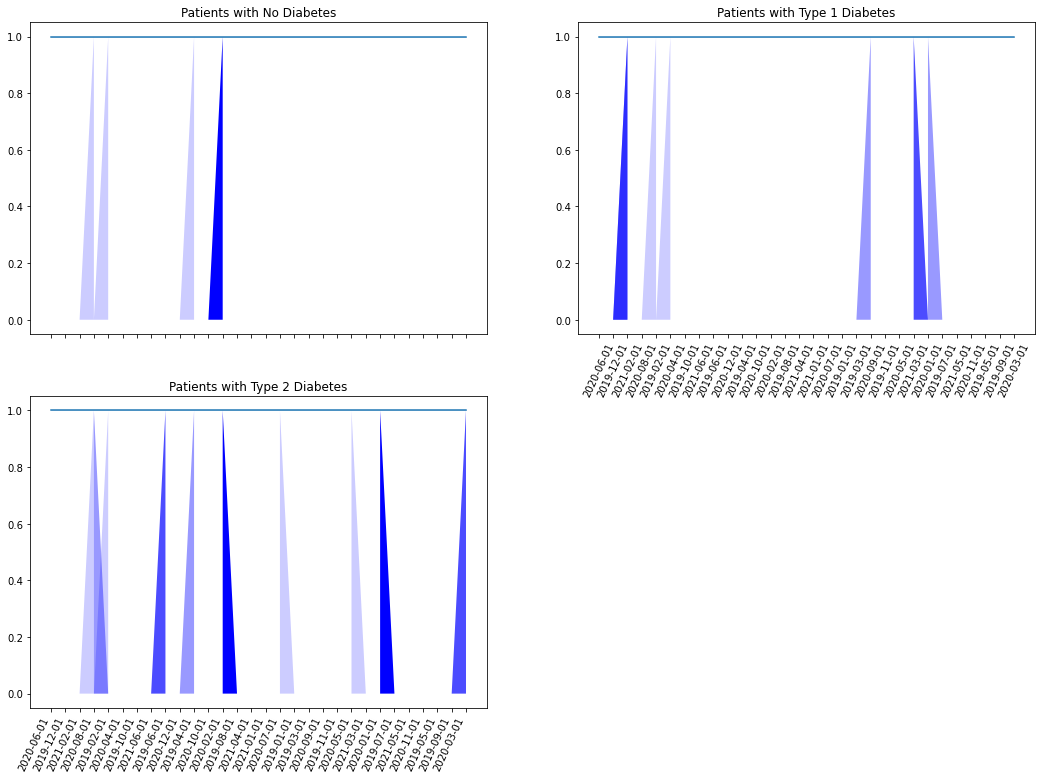

In [10]:
# Total number
fig, axes = plt.subplots(2,2, figsize=(18, 14))
fig.delaxes(ax=axes[1,1])
create_chart('Patients with No Diabetes', df_input, axes[0,0])
create_chart('Patients with Type 1 Diabetes', df_t1dm, axes[0,1])
create_chart('Patients with Type 2 Diabetes', df_t2dm, axes[1,0])
fig.autofmt_xdate(rotation=65)
axes[0,1].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
plt.savefig('../output/total_by_dm.png')
plt.show()

### By Demographics

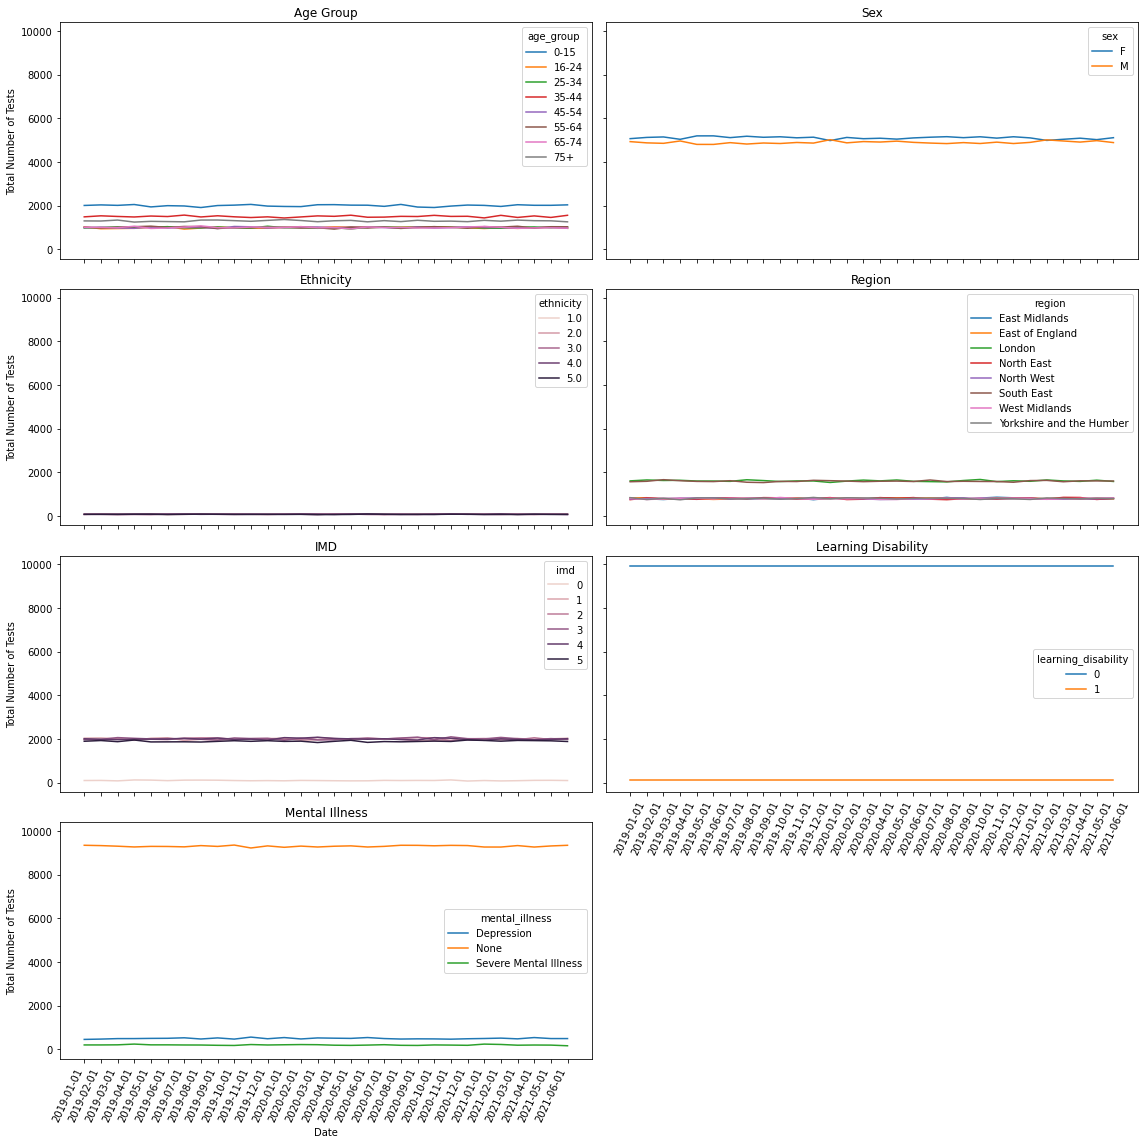

In [11]:
# Patients without diabetes
create_plotgrid('hba1c_test',df_age, df_sex, df_eth,
                df_reg, df_imd, df_ld, df_mi, 'Total Number of Tests',
                'total_nodm_by_group')

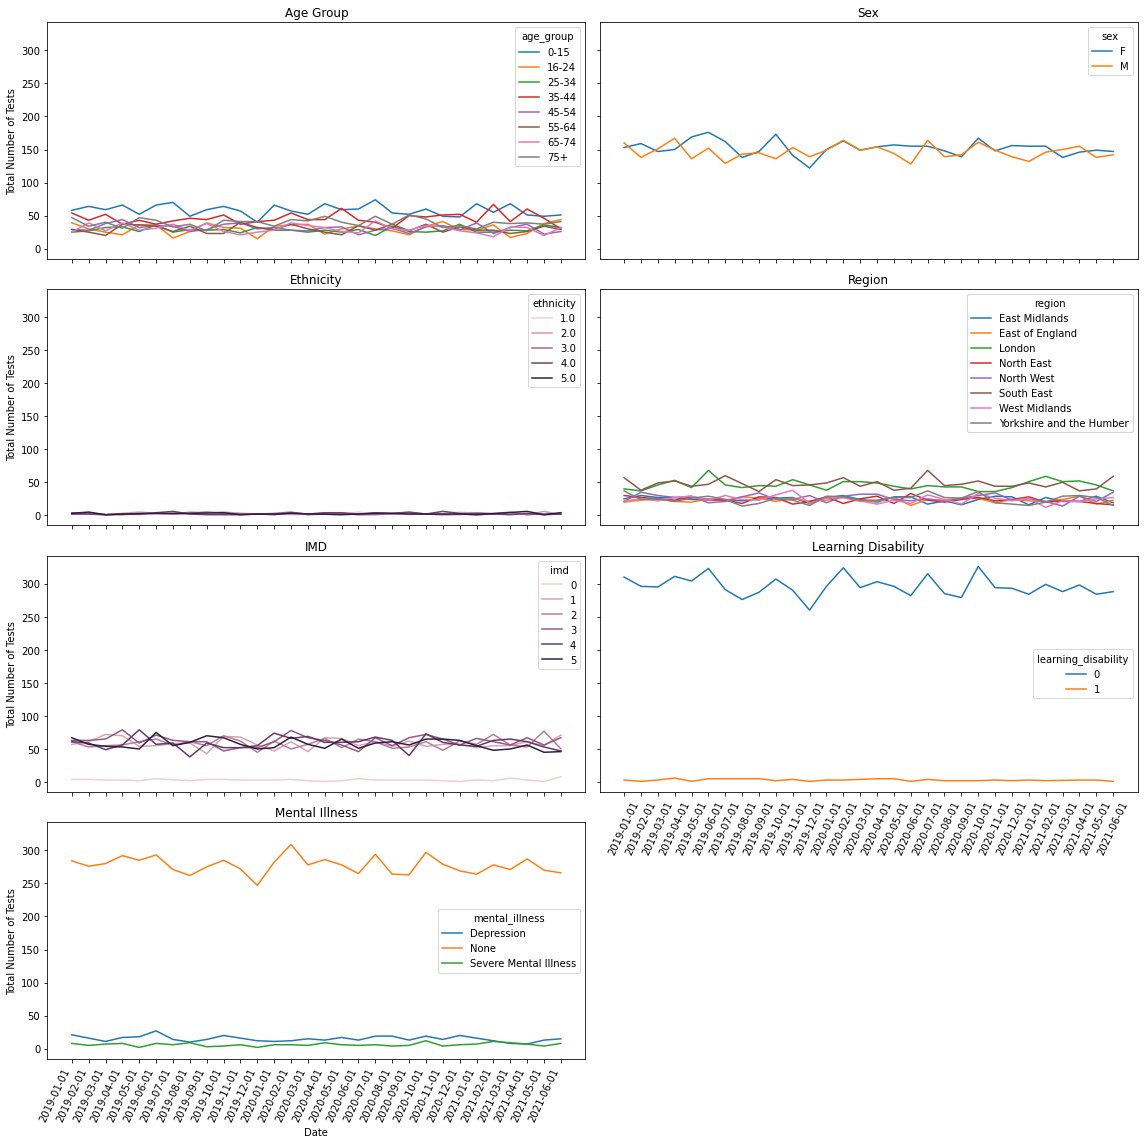

In [12]:
# Patients with T1DM
create_plotgrid('hba1c_test',df_age_t1dm, df_sex_t1dm, df_eth_t1dm,
                df_reg_t1dm, df_imd_t1dm, df_ld_t1dm, df_mi_t1dm, 'Total Number of Tests',
                'total_t1dm_by_group')

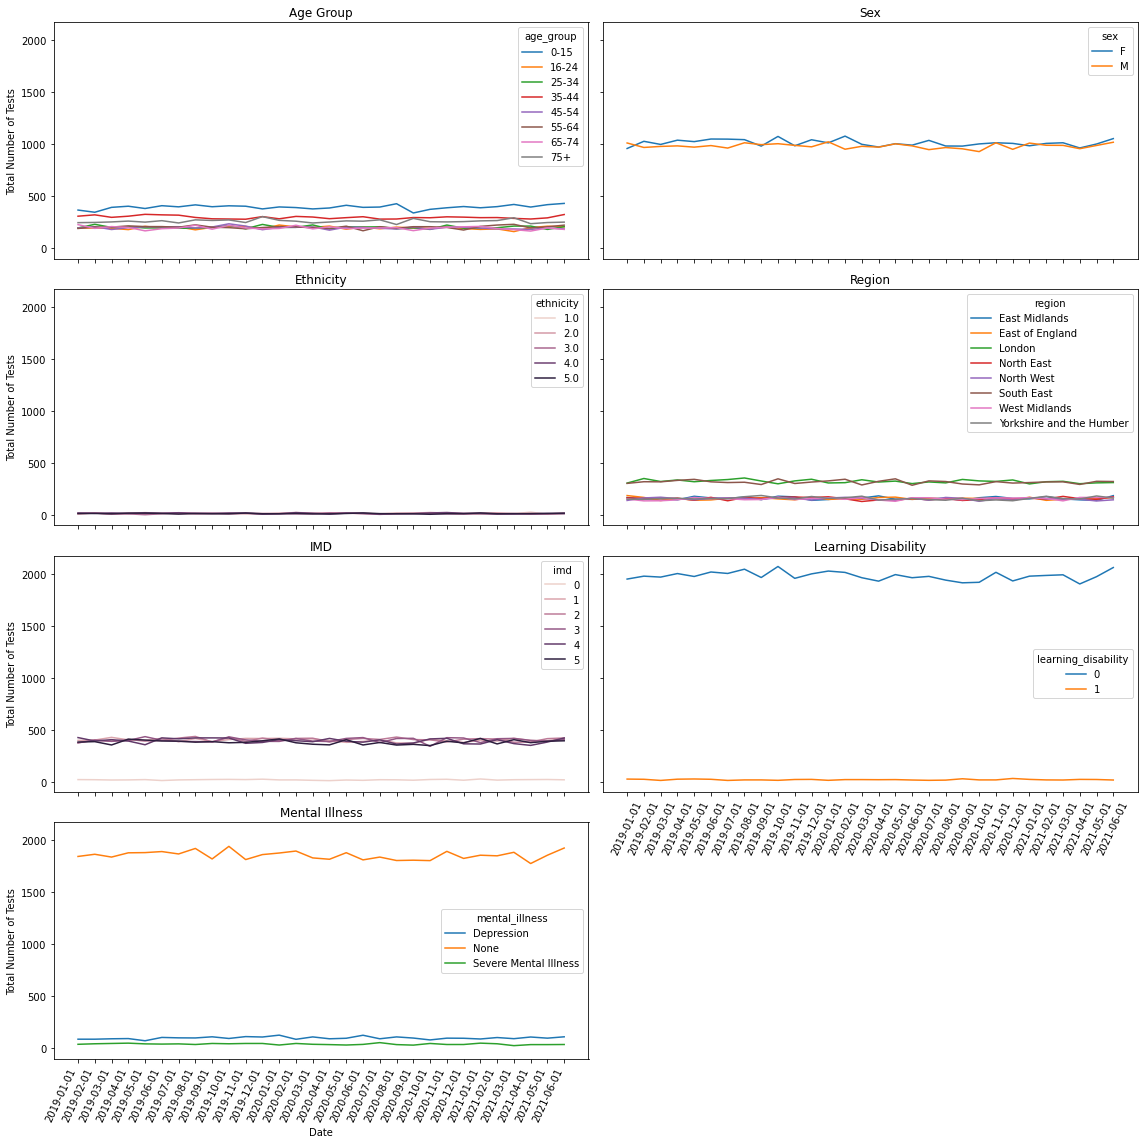

In [13]:
# Patients with T2DM
create_plotgrid('hba1c_test',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, 'Total Number of Tests',
                'total_t2dm_by_group')

_________

## Tests by Threshold for Those with T2DM

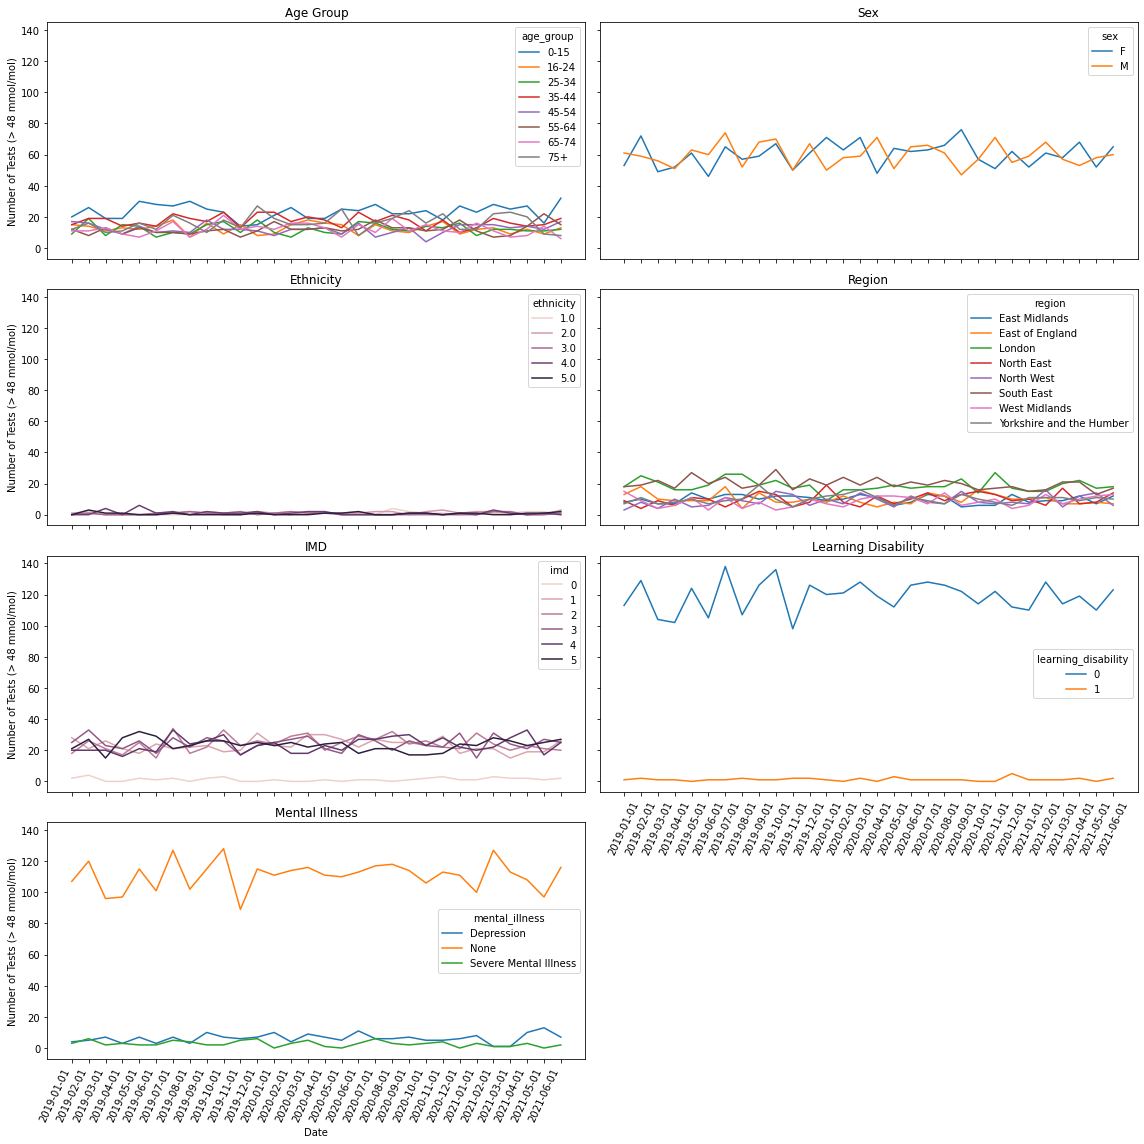

In [14]:
# > 48
create_plotgrid('hba1c_gt_48',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, 'Number of Tests (> 48 mmol/mol)',
                'gt48_t2dm_by_group')

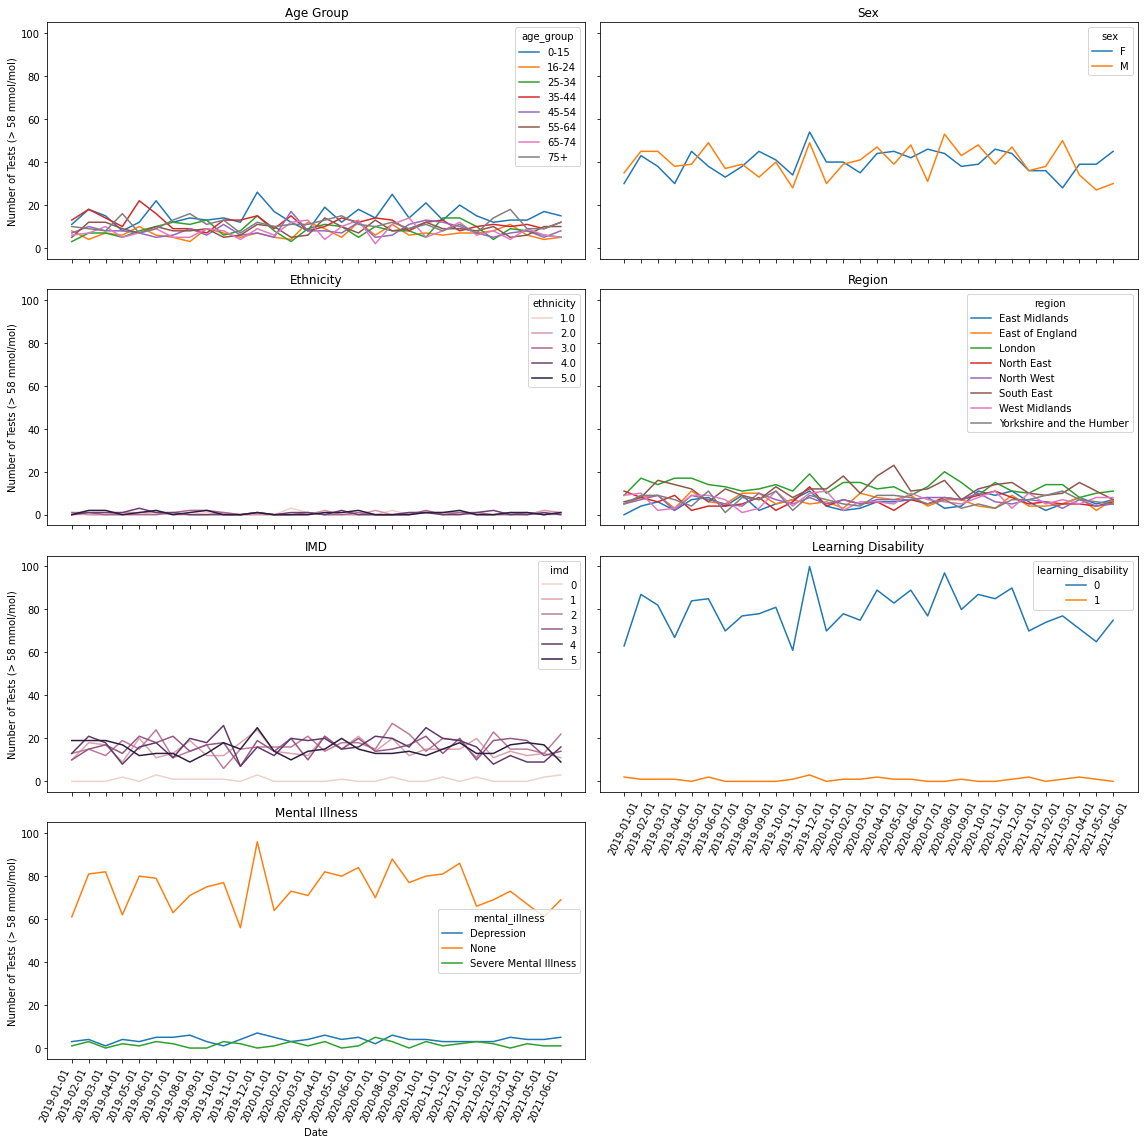

In [15]:
# > 58
create_plotgrid('hba1c_gt_58',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, 'Number of Tests (> 58 mmol/mol)',
                'gt58_t2dm_by_group')

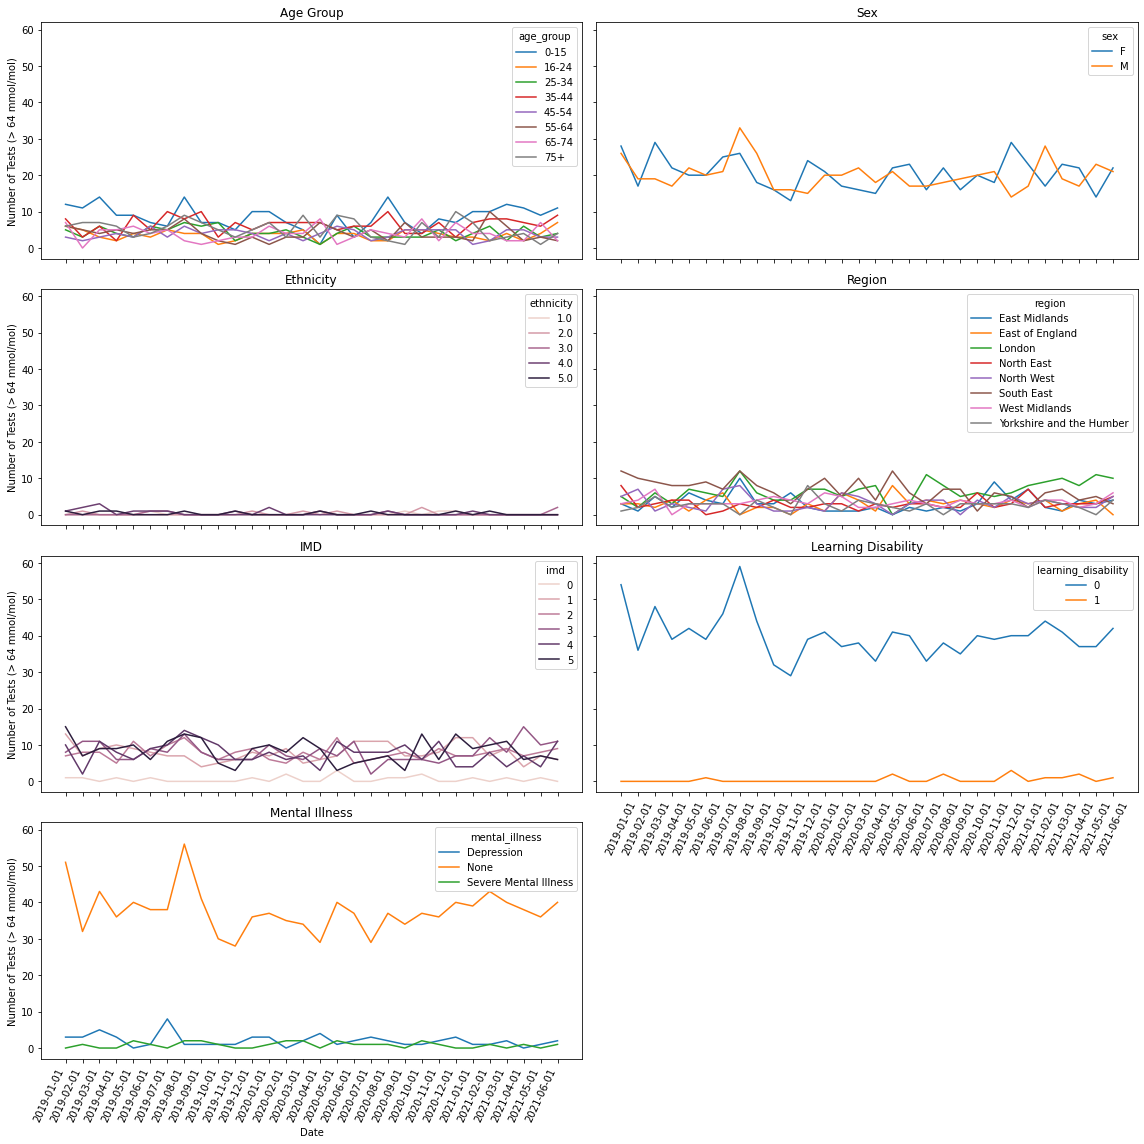

In [16]:
# > 64
create_plotgrid('hba1c_gt_64',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, 'Number of Tests (> 64 mmol/mol)',
                'gt64_t2dm_by_group')

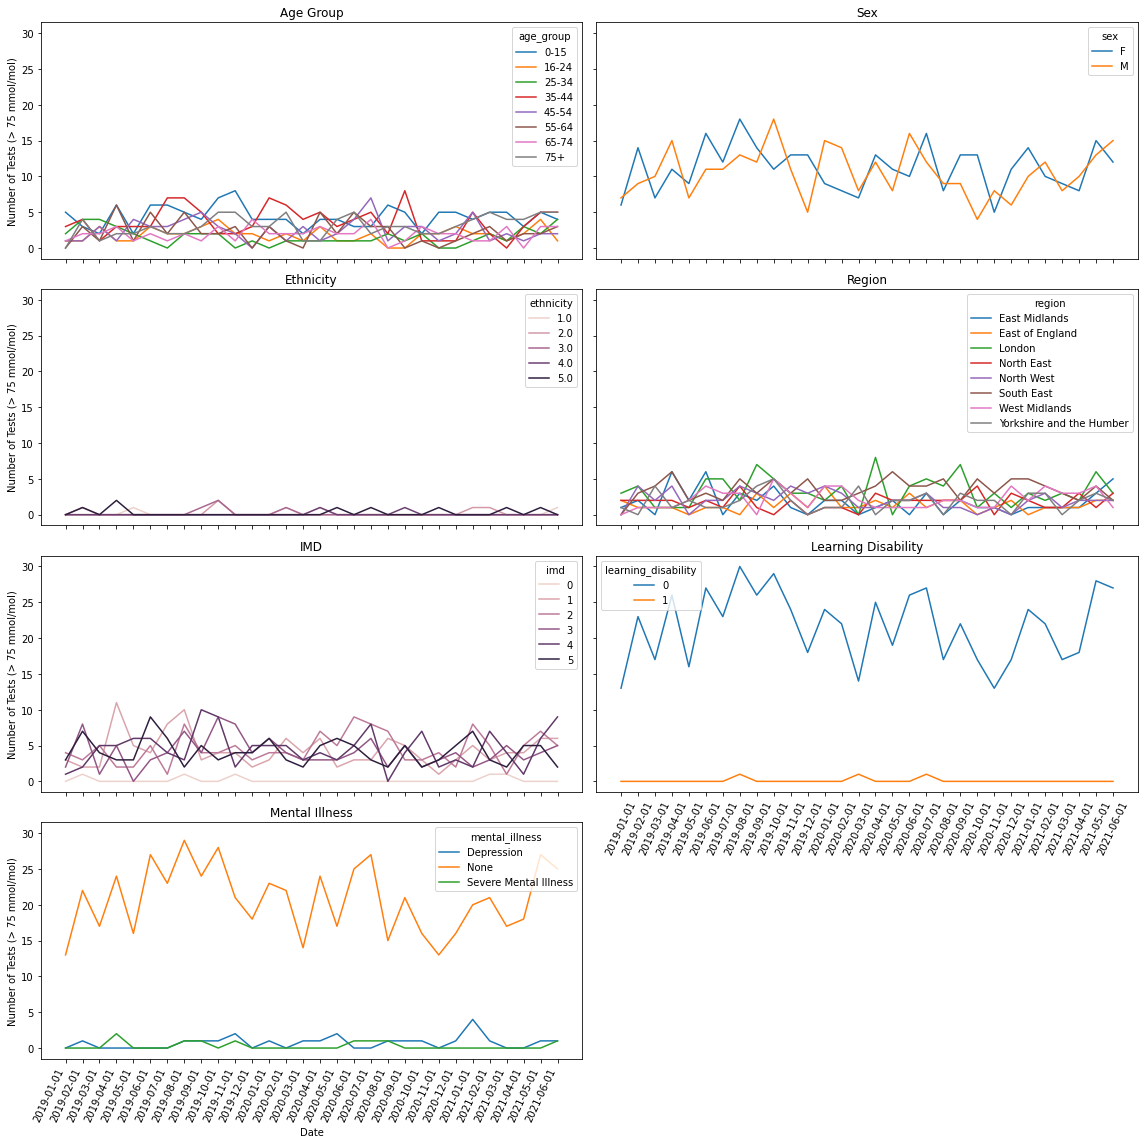

In [17]:
# > 75
create_plotgrid('hba1c_gt_75',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, 'Number of Tests (> 75 mmol/mol)',
                'gt75_t2dm_by_group')

___

## Percent of Tests by Target Threshold

In [18]:
# Subset to percentage variables
df_t2dm_pct = df_total_t2dm[['date','hba1c_gt_48_pct','hba1c_gt_58_pct',
                            'hba1c_gt_64_pct', 'hba1c_gt_75_pct']]

In [19]:
# Wide to long
df_t2dm_pct_wide = pd.melt(df_t2dm_pct, id_vars=['date'], value_vars=['hba1c_gt_48_pct','hba1c_gt_58_pct',
                                                                      'hba1c_gt_64_pct', 'hba1c_gt_75_pct']).reset_index(drop=True)

In [20]:
# Format variable
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_48_pct', 'variable'] = '> 48 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_58_pct', 'variable'] = '> 58 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_64_pct', 'variable'] = '> 64 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_75_pct', 'variable'] = '> 75 mmol/mol'
df_t2dm_pct_wide = df_t2dm_pct_wide.rename(columns={'variable':'threshold'})

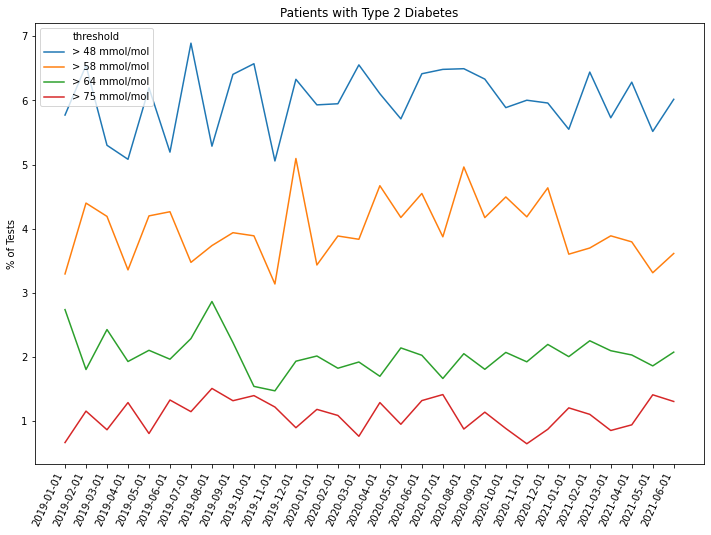

In [21]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='threshold', data=df_t2dm_pct_wide)
    
# Set title and make axes labels empty
ax.set_title('Patients with Type 2 Diabetes')
ax.set_xlabel('')
ax.set_ylabel('% of Tests')
fig.autofmt_xdate(rotation=65)

plt.savefig('../output/pct_t2dm.png')
plt.show()

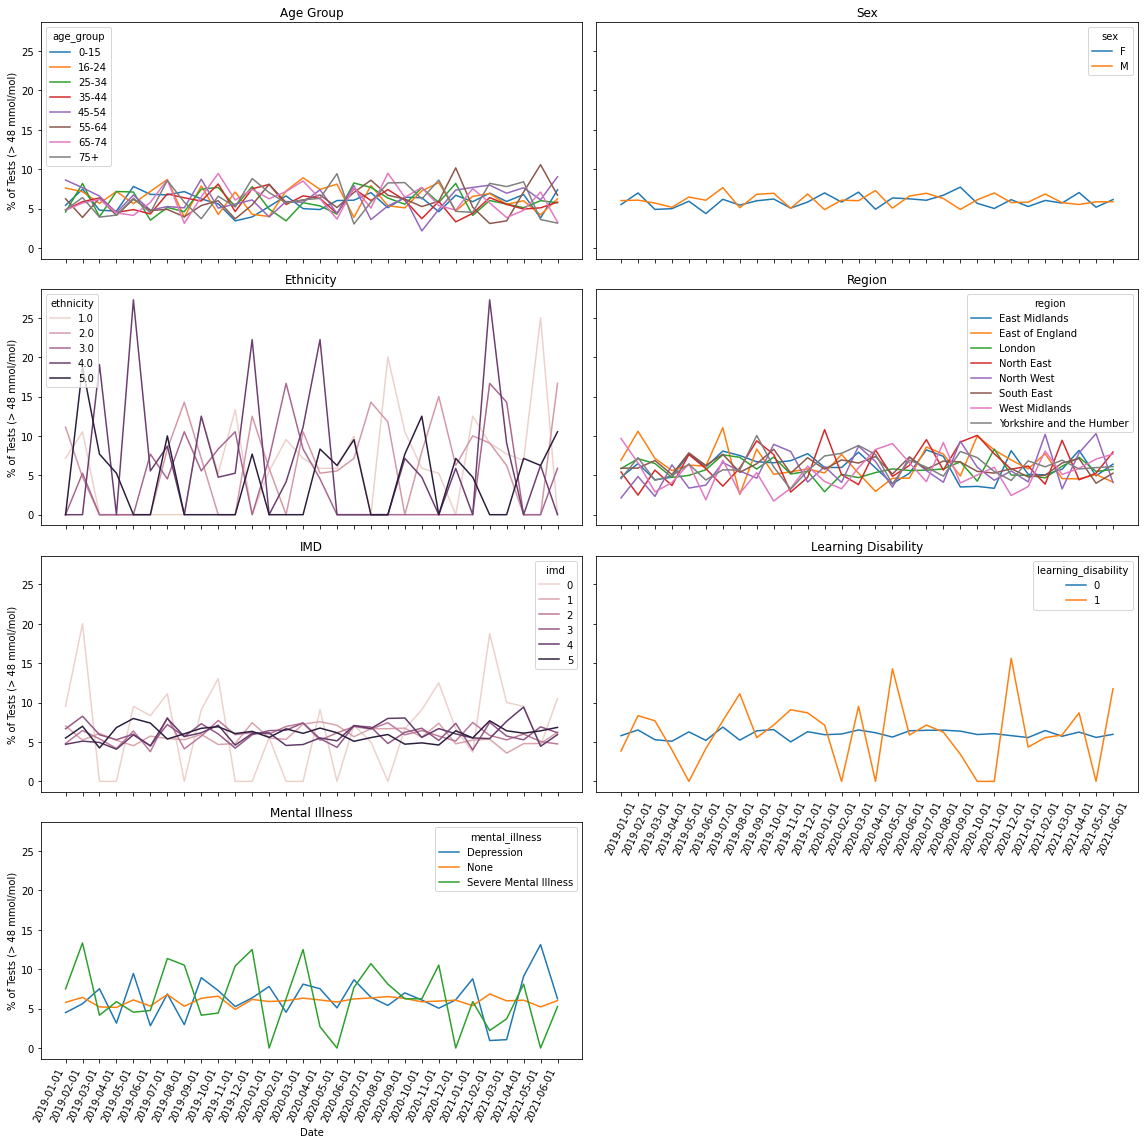

In [22]:
# > 48
create_plotgrid('hba1c_gt_48_pct',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, '% of Tests (> 48 mmol/mol)',
                'pct_t2dm_gt48')

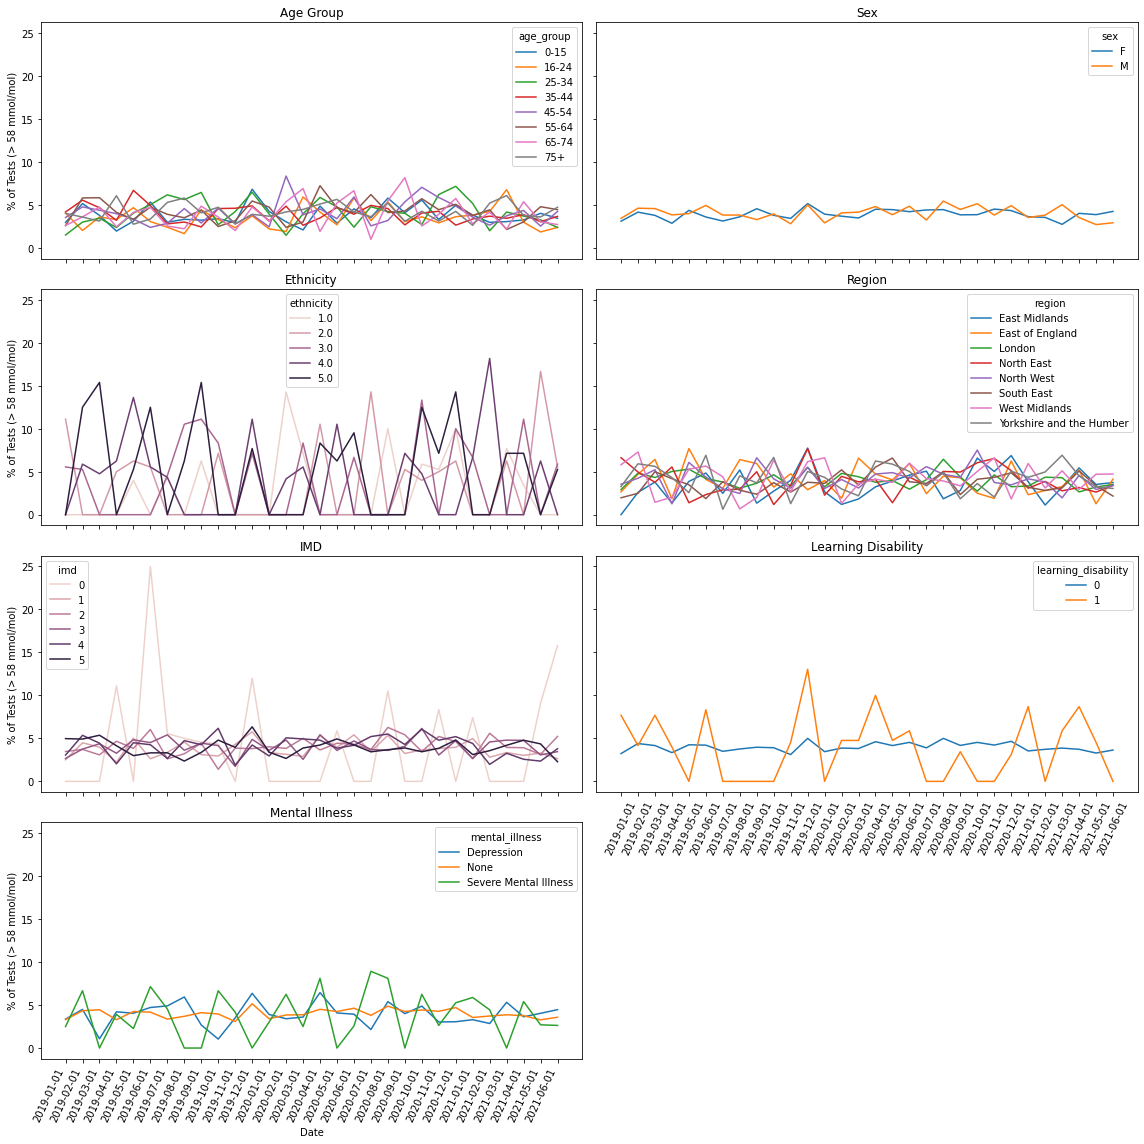

In [23]:
# > 58
create_plotgrid('hba1c_gt_58_pct',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, '% of Tests (> 58 mmol/mol)',
                'pct_t2dm_gt58')

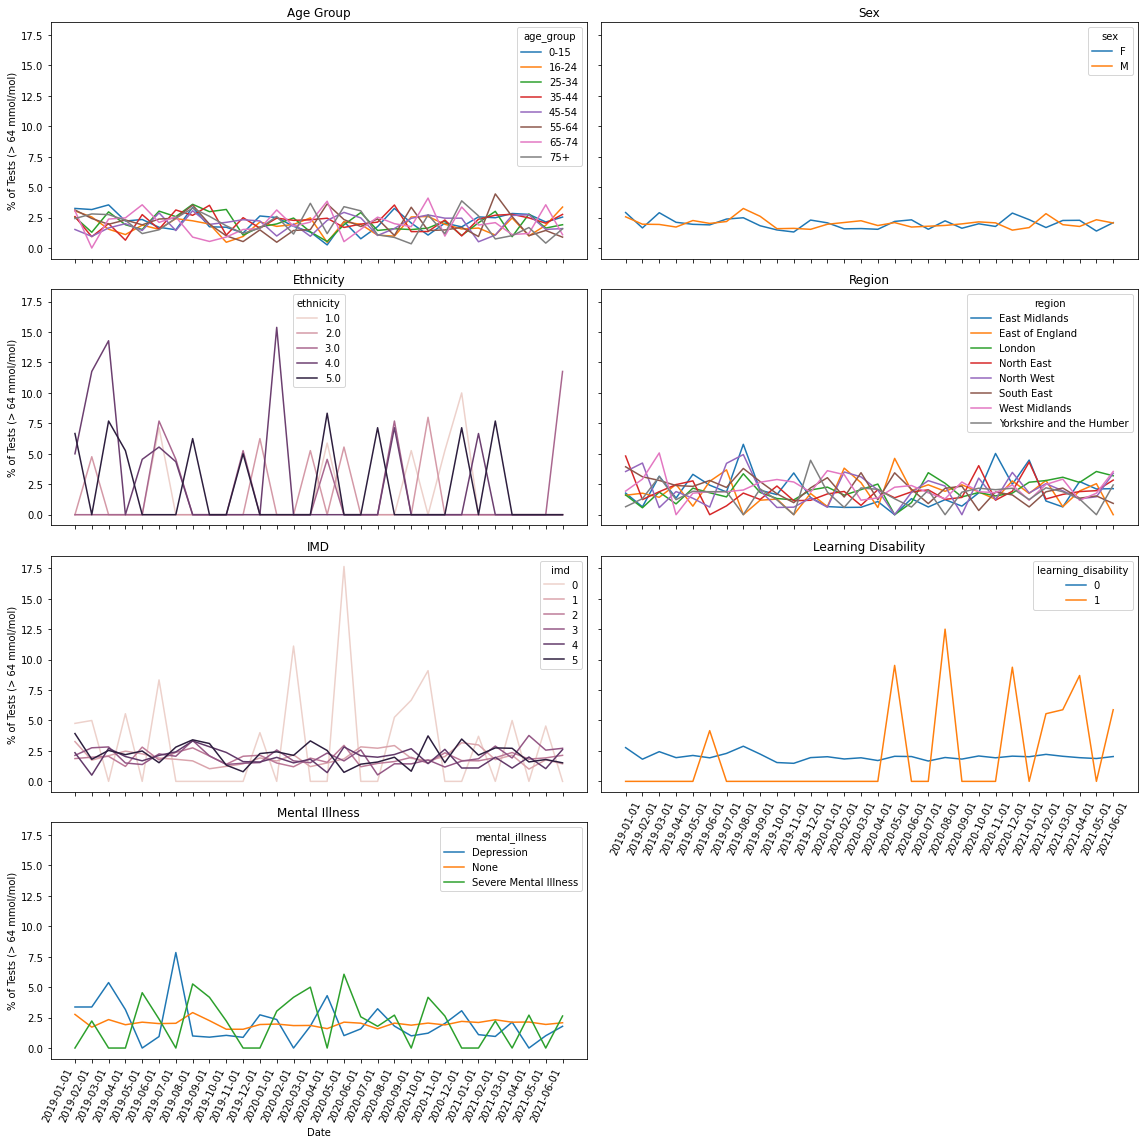

In [24]:
# > 64
create_plotgrid('hba1c_gt_64_pct',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, '% of Tests (> 64 mmol/mol)',
                'pct_t2dm_gt64')

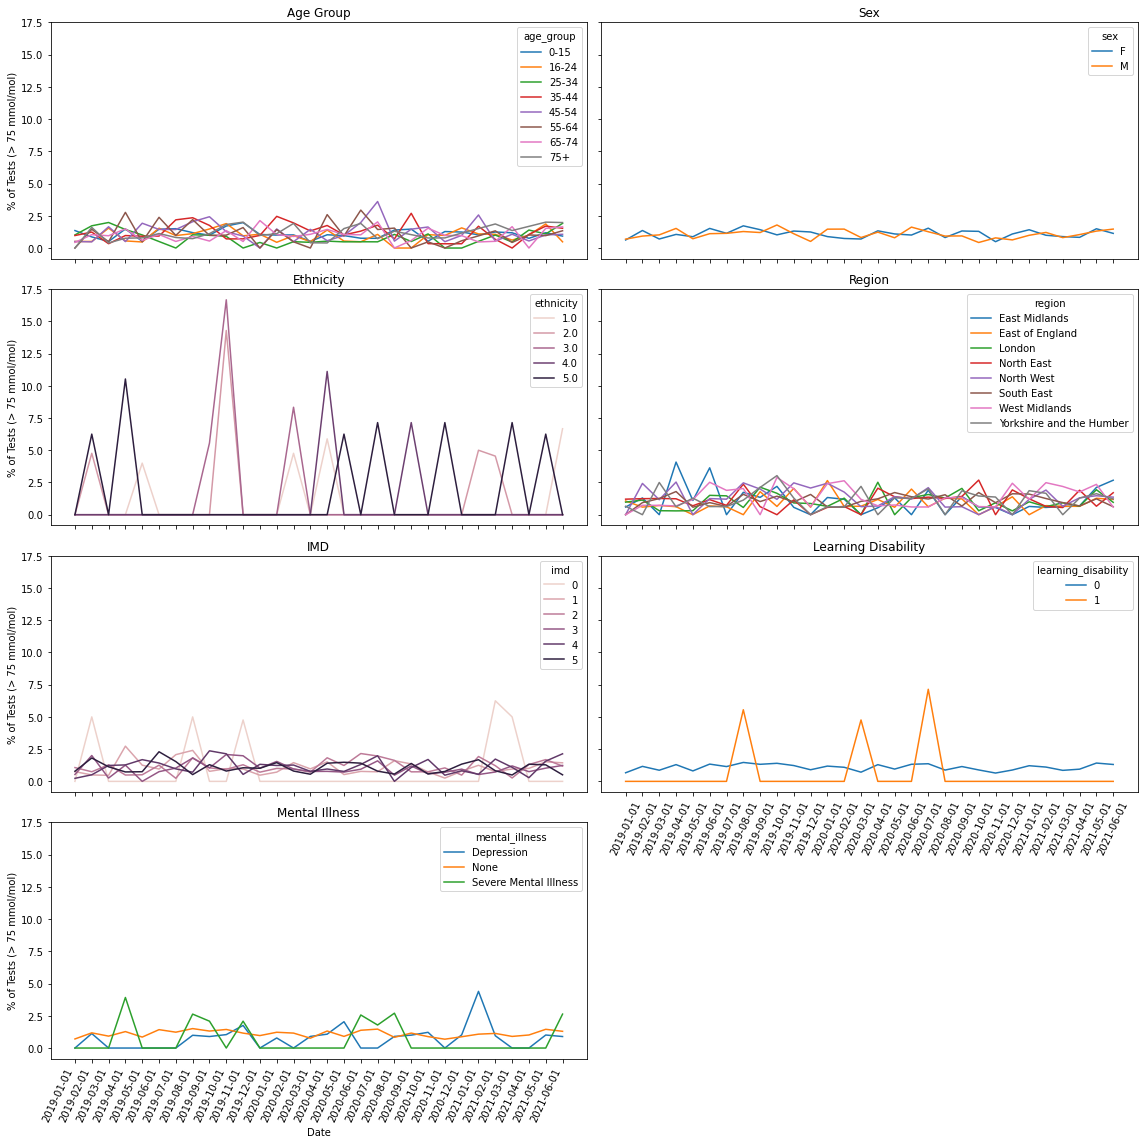

In [25]:
# > 75
create_plotgrid('hba1c_gt_75_pct',df_age_t2dm, df_sex_t2dm, df_eth_t2dm,
                df_reg_t2dm, df_imd_t2dm, df_ld_t2dm, df_mi_t2dm, '% of Tests (> 75 mmol/mol)',
                'pct_t2dm_gt75')

______

## Median of Test Values

In [26]:
# Get patient subset with poor glycemic control prior to the pandemic
pat_subset = df_t2dm.loc[df_t2dm.prev_hba1c_mmol_per_mol_date > 58]['patient_id'].unique()
df_t2dm_subset = df_t2dm.loc[df_t2dm.patient_id.isin(pat_subset)]

In [27]:
# 58-74 range 
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 58) & 
                   (df_t2dm_subset.prev_hba1c_mmol_per_mol < 75), 
                   'hba1c_val_58_74'] = df_t2dm_subset.hba1c_mmol_per_mol

# > 75
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 75),
                   'hba1c_val_75'] = df_t2dm_subset.hba1c_mmol_per_mol

In [28]:
# Get median of test values
def gen_median(df_in):
    return df_in[['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date']).median().reset_index()

def gen_median_by_group(df_in, group):
    return df_in[[group] + ['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date', group]).median().reset_index()

In [29]:
df_med_t2dm = gen_median(df_t2dm_subset)
df_med_t2dm_age = gen_median_by_group(df_t2dm_subset, 'age_group')
df_med_t2dm_sex = gen_median_by_group(df_t2dm_subset, 'sex')
df_med_t2dm_eth = gen_median_by_group(df_t2dm_subset, 'ethnicity')
df_med_t2dm_reg = gen_median_by_group(df_t2dm_subset, 'region')
df_med_t2dm_imd = gen_median_by_group(df_t2dm_subset, 'imd')
df_med_t2dm_ld = gen_median_by_group(df_t2dm_subset, 'learning_disability')
df_med_t2dm_mi = gen_median_by_group(df_t2dm_subset, 'mental_illness')

In [30]:
df_med_t2dm_wide = pd.melt(df_med_t2dm, id_vars=['date'], value_vars=['hba1c_val_58_74', 'hba1c_val_75'])

In [31]:
# Format variable
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_58_74', 'variable'] = '58-74 mmol/mol'
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_75', 'variable'] = '> 75 mmol/mol'
df_med_t2dm_wide = df_med_t2dm_wide.rename(columns={'variable':'range_in_prev_15_mo'})

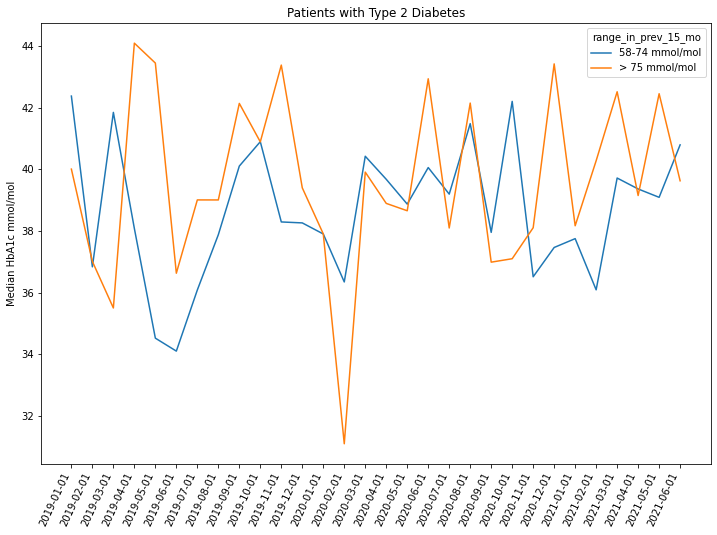

In [32]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='range_in_prev_15_mo', data=df_med_t2dm_wide)
    
# Set title and make axes labels empty
ax.set_title('Patients with Type 2 Diabetes')
ax.set_xlabel('')
ax.set_ylabel('Median HbA1c mmol/mol')
fig.autofmt_xdate(rotation=65)

plt.savefig('../output/med_t2dm.png')
plt.show()

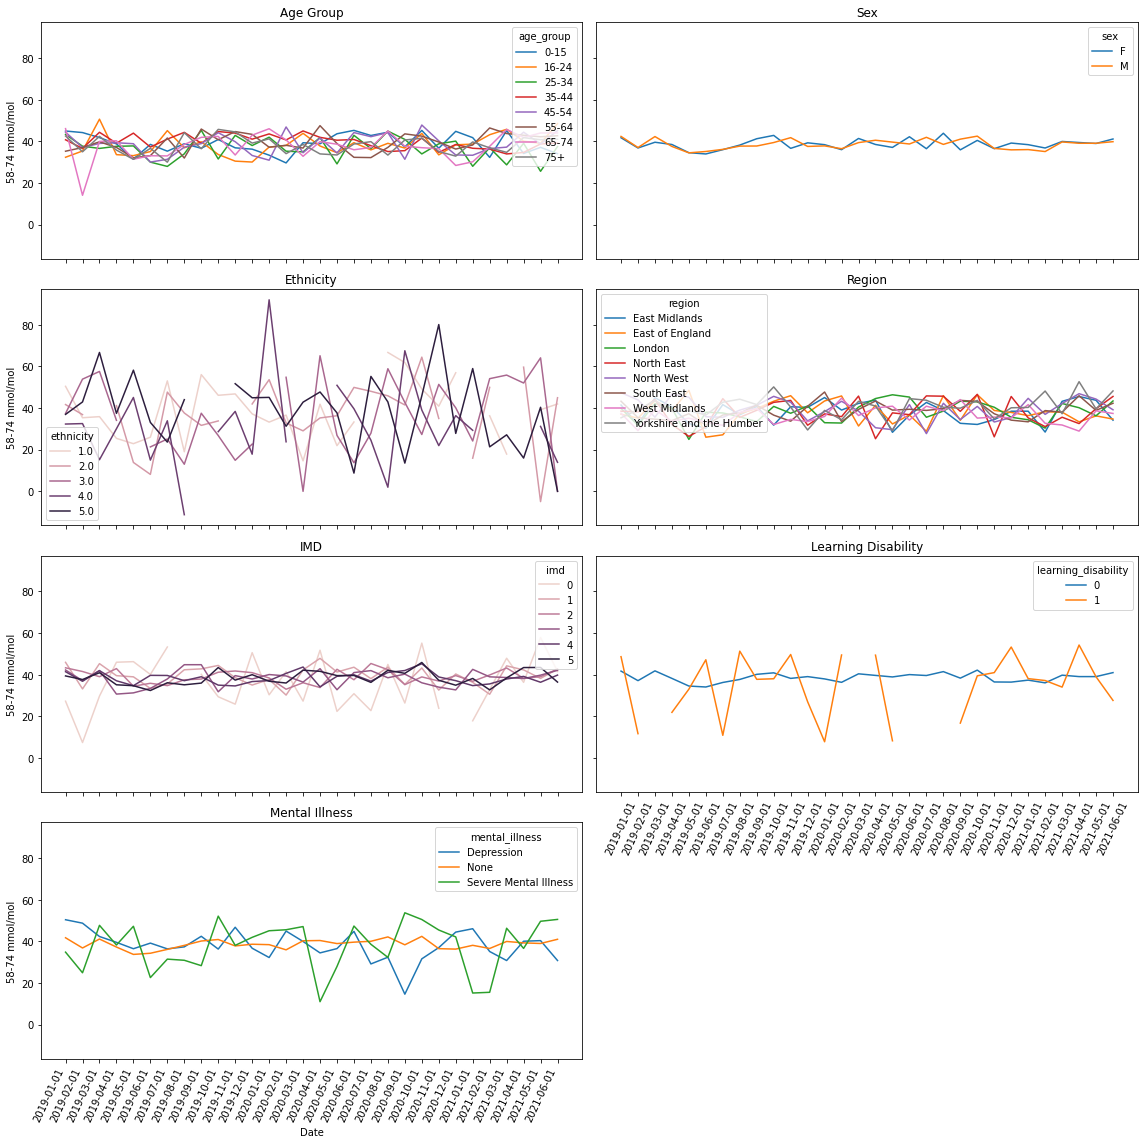

In [33]:
# 58-74 mmol/mol
create_plotgrid('hba1c_val_58_74',df_med_t2dm_age, df_med_t2dm_sex, df_med_t2dm_eth,
                df_med_t2dm_reg, df_med_t2dm_imd, df_med_t2dm_ld, df_med_t2dm_mi, '58-74 mmol/mol',
                'med_t2dm_58_74')

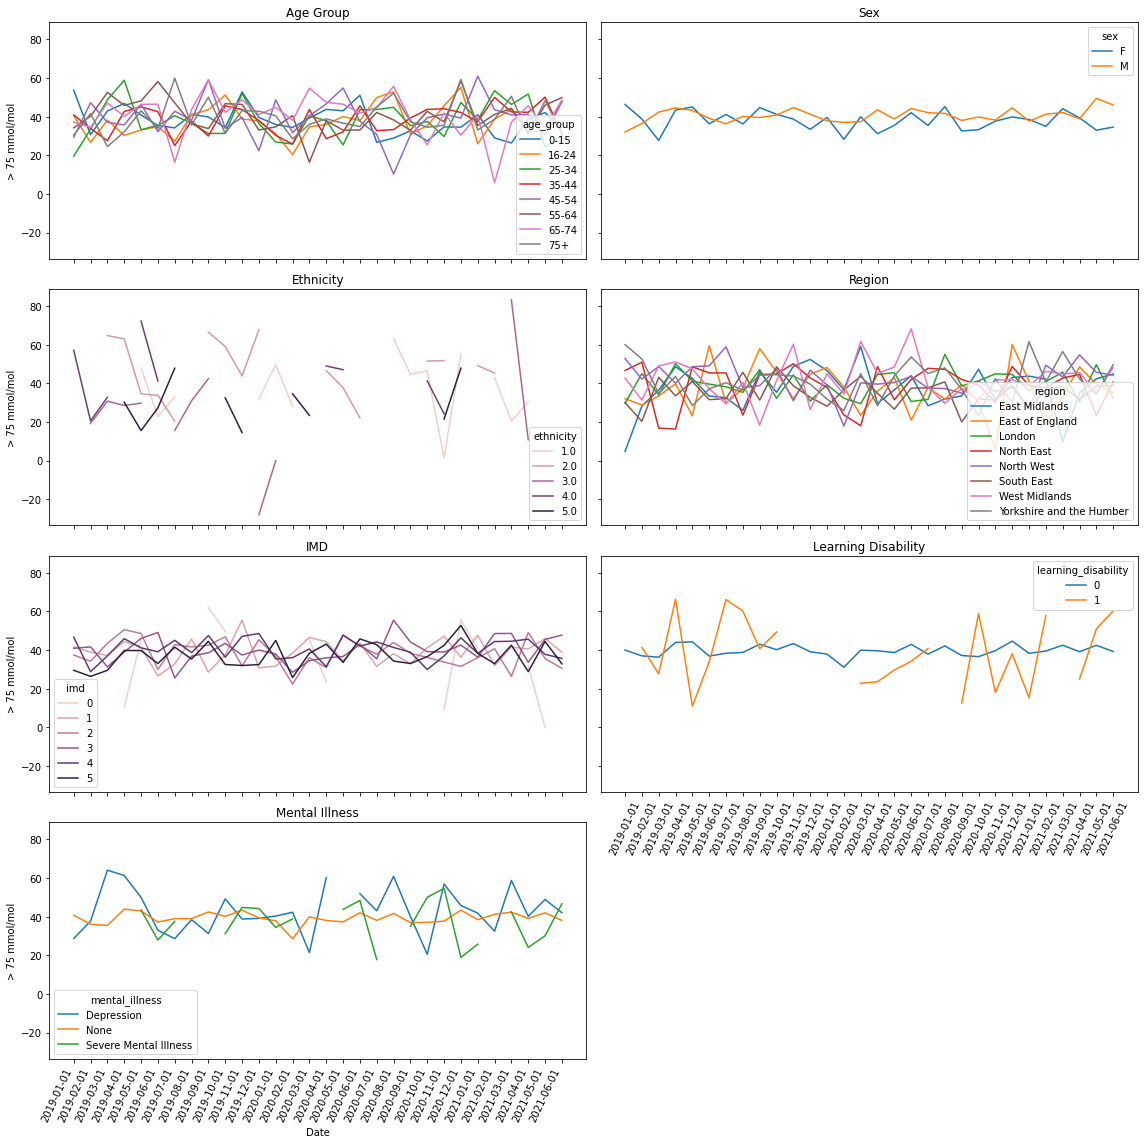

In [34]:
# > 75 mmol/mol
create_plotgrid('hba1c_val_75',df_med_t2dm_age, df_med_t2dm_sex, df_med_t2dm_eth,
                df_med_t2dm_reg, df_med_t2dm_imd, df_med_t2dm_ld, df_med_t2dm_mi, '> 75 mmol/mol',
                'med_t2dm_gt75')